# Testing with test set

    Load test images, these images are already preprocessed and only those with nodules(partially cropped) are used.
    feed into model and get the confusion matrix
    visualize


In [1]:
# Reset VRAM
from numba import cuda 
device = cuda.get_current_device()
device.reset()

In [3]:
import torch
import torch.nn as nn
# import torch.nn.functional as F 
from torchvision import datasets
# from torchvision import transforms
from torch.utils.data import DataLoader
import os
import glob
import numpy as np
import time
import datetime
from ipywidgets import interact
import matplotlib.pyplot as plt
# from PIL import Image
from skimage.transform import rotate, resize
from random import randint
from torch.utils.tensorboard import SummaryWriter

In [6]:
train_on_gpu = torch.cuda.is_available()
device = torch.device("cuda" if train_on_gpu else "cpu")
print('GPU_available :',train_on_gpu)
print(torch.cuda.get_device_name(torch.cuda.current_device()))

GPU_available : True
GeForce RTX 2070 with Max-Q Design


In [7]:
class LunaBlockDown(nn.Module):
    def __init__(self, in_channels, conv_channels):
        super(LunaBlockDown, self).__init__()
        self.conv1 = nn.Conv3d(
            in_channels, conv_channels, kernel_size=3, padding=1, bias=True)
        self.relu1 = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv3d(
            conv_channels, conv_channels, kernel_size=3, padding=1, bias=True)
        self.relu2 = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool3d(2,2)
        self.batchnorm = nn.BatchNorm3d(conv_channels)
        
        
    def forward(self, input_batch):
        block_out = self.conv1(input_batch)
        block_out = self.relu1(block_out)
        block_out = self.conv2(block_out)
        block_out = self.batchnorm(block_out)
        block_out = self.relu2(block_out)
        
        return self.maxpool(block_out), block_out     

class LunaBlockUp(nn.Module):
    def __init__(self, in_channels, conv_channels):
        super(LunaBlockUp, self).__init__()
        self.t_conv_layer = nn.ConvTranspose3d(
            in_channels, in_channels,kernel_size =2, stride=2, padding=0, bias = False)
        self.conv1 = nn.Conv3d(
            in_channels, conv_channels, kernel_size=3, padding=1, bias=True)
        self.relu1 = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv3d(
            conv_channels, conv_channels, kernel_size=3, padding=1, bias=True)
        self.relu2 = nn.ReLU(inplace=True)
        self.batchnorm = nn.BatchNorm3d(conv_channels)

    def forward(self, input_batch):
        block_out = self.t_conv_layer(input_batch)
        block_out = self.conv1(block_out)
        block_out = self.batchnorm(block_out)
        block_out = self.relu1(block_out)
        block_out = self.conv2(block_out)
        block_out = self.batchnorm(block_out)
        block_out = self.relu2(block_out)
        
        return block_out
    
class LunaModel(nn.Module):
    def __init__(self, in_channels=1, conv_channels=32):
        super(LunaModel, self).__init__()
        self.block1 = LunaBlockDown(in_channels, conv_channels) 
        self.block2 = LunaBlockDown(conv_channels, conv_channels * 2) 
        self.block3 = LunaBlockDown(conv_channels * 2,conv_channels * 4) 
        self.block4 = LunaBlockUp(conv_channels * 4, conv_channels * 4)
        self.block5 = LunaBlockUp(conv_channels * 8, conv_channels*2)    
        self.block6 = LunaBlockUp(conv_channels*4, conv_channels)  
        self.conv1 = nn.Conv3d(
            conv_channels*2, conv_channels, kernel_size=3, padding=1, bias=True)
        self.relu1 = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv3d(
            conv_channels, conv_channels, kernel_size=3, padding=1, bias=True)
        self.relu2 = nn.ReLU(inplace=True)
        self.conv3 = nn.Conv3d(
            conv_channels, in_channels, kernel_size=1, padding=0, bias=True)
        self.batchnorm = nn.BatchNorm3d(conv_channels)
        self.dropout = nn.Dropout(p=0.2, inplace=True)

    
    def forward(self, input_batch):
        block_out, layer1 = self.block1(input_batch) #128x128x20
        block_out, layer2 = self.block2(block_out) #64x64x10
        block_out, layer3 = self.block3(block_out) #32x32x5
        block_out = self.block4(block_out)
        block_out = torch.cat((block_out, layer3), dim=1)
        block_out = self.dropout(block_out)
        block_out = self.block5(block_out)
        block_out = torch.cat((block_out, layer2), dim=1)
        block_out = self.dropout(block_out)
        block_out = self.block6(block_out)
        block_out = torch.cat((block_out, layer1), dim=1)
        block_out = self.dropout(block_out)
        block_out = self.conv1(block_out)
        block_out = self.batchnorm(block_out)
        block_out = self.relu1(block_out)
        block_out = self.conv2(block_out)
        block_out = self.batchnorm(block_out)
        block_out = self.relu2(block_out)
        block_out = self.conv3(block_out)
        
        return torch.sigmoid(block_out) 
    
    def _init_weights(self):
        for m in self.modules():
            if type(m) in {
                nn.Conv3d,
                nn.ConvTranspose3d
            }:nn.init.kaiming_normal_(
                m.weight.data, a=0, mode='fan_out', nonlinearity='relu', 
            ) 
            if m.bias is not None:
                fan_in, fan_out = nn.init._calculate_fan_in_and_fan_out(m.weight.data) 
                bound = 1 / math.sqrt(fan_out) 
                nn.init.normal_(m.bias, -bound, bound)

                
model = LunaModel()
if train_on_gpu:
    model.cuda()
model

In [9]:
import torch.optim as optim
from torch.utils.data.sampler import SubsetRandomSampler
from torch.autograd import Variable

class diceloss(torch.nn.Module):
    def init(self):
        super(diceLoss, self).init()
    def forward(self,y_true, y_pred, epsilon=0.00001):
        axis = tuple(range(1, len(y_pred.shape)-1)) 
        dice_numerator = torch.sum(y_pred*y_true,axis=axis)*2 + epsilon
        dice_denominator = torch.sum(y_true**2,axis=axis) + torch.sum(y_pred**2,axis=axis) + epsilon
        dice_loss = 1-torch.mean(dice_numerator/dice_denominator)
        return dice_loss
criterion = diceloss()

In [10]:
# compute confusion matrix
def compute_CM (pred, label, threshold=0.5):
    """Only accepts numpy.."""
    threshold = 0.5
    pred[pred >= threshold] = 1.0
    pred[pred < threshold] = 0.0
    pred = pred.detach().cpu().numpy()
    label = label.detach().cpu().numpy()
    tp = np.sum((pred == 1) & (label==1))
    tn = np.sum((pred == 0) & (label==0))
    fp = np.sum((pred == 1) & (label==0))
    fn = np.sum((pred == 0) & (label==1))
    accuracy = ((tp+tn)/(tp+tn+fp+fn))
    sensitivity = ((tp/(tp+fn)))
    specificity = (tn/(tn+fp))
    ppv = (tp/(tp+fp))
    return round(accuracy*100, 2),round(sensitivity*100, 2),round(specificity*100, 2),round(ppv*100, 2)

## Testing with test set

1. Load image size batch_size x channel(2) x 128 x 512 x 512
2. Select 1 out of batch (squeeze) -> chunk into 2x32x32x32,  4x16x16 = 1024 chunks
3. Load model, set model to eval()
4. Load as tensor, split the label and image
5. Input image into the model - get prediction
6. calculate loss and confusion matrix
7. reassemble and return np.array
7. visualize

In [11]:
class TestLoaderImg(torch.utils.data.Dataset):
    def __init__(self, folder_path="test5"):
        super(TestLoaderImg, self).__init__()
        self.img_files = glob.glob(os.path.join(folder_path, '*.npy'))

    def __getitem__(self, index):
            img_path = self.img_files[index]
            data = np.load(img_path)
            return torch.from_numpy(data).float()
                                   
    def __len__(self):
        return len(self.img_files)

https://discuss.pytorch.org/t/patch-making-does-pytorch-have-anything-to-offer/33850/14


In [12]:
# This will chunk the image into 16 times in each axis: 512/16-> 32 = 32x32x32 output, + return the unfold_shape to keep the positional data.
def get_chunks(x):
    kc, kh, kw = 32, 32, 32  # kernel size
    dc, dh, dw = 32, 32, 32  # stride
    patches = x.unfold(1, kc, dc).unfold(2, kh, dh).unfold(3, kw, dw)
    unfold_shape = patches.size()
    patches = patches.contiguous().view(patches.size(0), -1, kc, kh, kw)
    print(patches.shape)
    return patches, unfold_shape

# Reshape back
def Reshape(patches, unfold_shape):
    patches_orig = patches.view(unfold_shape)
    output_c = unfold_shape[1] * unfold_shape[4]
    output_h = unfold_shape[2] * unfold_shape[5]
    output_w = unfold_shape[3] * unfold_shape[6]
    patches_orig = patches_orig.permute(0, 1, 4, 2, 5, 3, 6).contiguous()
    patches_orig = patches_orig.view(1, output_c, output_h, output_w)
    return patches_orig

In [13]:
test_dataset_big = TestLoaderImg(folder_path = "test5-big")
test_loader_big = DataLoader(test_dataset_big, batch_size = 1, shuffle=True, num_workers=0)

In [14]:
test_dataset_chunk = TestLoaderImg(folder_path = "test5")
# test_dataset_chunk = TestLoaderImg(folder_path = "train5-2")
test_loader_chunk = DataLoader(test_dataset_chunk, batch_size = 1, shuffle=True, num_workers=0)

In [15]:
a = next(iter(test_loader_chunk))
a.shape

torch.Size([1, 2, 32, 32, 32])

# Test

In [16]:
# ###################### # Test the model # ###################### 
# start_time = time.time()
save = 'save/save49.pt'
# model.load_state_dict(torch.load(save))
# model.eval()
# test_loss, test_sensitivity, test_specificity, test_accuracy, test_ppv = 0.0, 0.0, 0.0, 0.0, 0.0

# count = 0
# for data_chunk in test_loader_chunk:
#     data_chunk = data_chunk.squeeze()
#     i, l = data_chunk[0].unsqueeze(0).unsqueeze(0).to(device), data_chunk[1].unsqueeze(0).unsqueeze(0).to(device)
#     pred = model(i)
#     loss = criterion(pred,l)
# #     pred = pred.detach().cpu().numpy()
#     accuracy, sensitivity, specificity, ppv = compute_CM(pred,l)
    
#     if not (np.isnan(sensitivity)or np.isnan(ppv)):
#         print("Accuracy: {}%, Sensitivity: {}%, Specificity: {}%, PPV: {}%".format(accuracy, sensitivity, specificity, ppv))
#         test_loss += loss.item()*i.size(0) #.item( ) is important, else will run out of memory
#         test_sensitivity += sensitivity
#         test_specificity += specificity
#         test_accuracy += accuracy
#         test_ppv += ppv
#         count += 1
# if count ==0:
#     count = 1
# test_loss = test_loss/count
# test_sensitivity = test_sensitivity/count
# test_specificity = test_specificity/count
# test_accuracy = test_accuracy/count
# test_ppv = test_ppv/count
# print("test_loss: {}, test_accuracy: {}%, test_sensitivity: {}%, test_specificity: {}%, test_PPV: {}%".format(test_loss, test_accuracy, test_sensitivity, test_specificity, test_ppv))
# print("count: ",count)
# print("--- %s seconds ---" % (time.time() - start_time))

In [17]:
def find_marked(display_label):
    layer_i = []
    for i in range(display_label.shape[0]):
        test_mask = display_label[i, :, :]
        if np.sum(test_mask)>0:
            layer_i.append(i)
    print("layers:", layer_i)
    if len(layer_i)>0:
        return layer_i[int(len(layer_i)/2)]
    else:
        return display_label.shape[0]/2

In [18]:
# model.load_state_dict(torch.load(save))
# model.eval()
# data_chunk = next(iter(test_loader_chunk))

# display_pred = model(data_chunk[:,0].unsqueeze(0).to(device)).squeeze().detach().cpu().numpy()
# display_label = data_chunk[:,1].squeeze().detach().cpu().numpy()
# display_image = data_chunk[:,0].squeeze().detach().cpu().numpy()

In [19]:
# def explore_3dimage(layer=find_marked(display_label)):
#     plt.figure(figsize=(5, 5))
#     plt.imshow(display_image[layer, :, :], cmap='gray');
#     global display_pred
#     mask = np.ma.masked_where((display_pred < 0.05), display_pred)
#     plt.imshow(mask[layer, :, :], cmap="Wistia", alpha=0.4);   #mask อยู่ตรงนี้นะ
#     label =  np.ma.masked_where((display_label < 0.05), display_label)
#     plt.imshow(label[layer, :, :], cmap="hsv", alpha=0.4);  #label อยู่ตรงนี้นะ/
#     plt.title('Label', fontsize=20)
#     plt.axis('off')
#     return layer

# interact(explore_3dimage, layer=(0, display_image.shape[0]))

# Visualize test image, pred

In [20]:
start_time = time.time()
model.load_state_dict(torch.load(save))
model.eval()
data = next(iter(test_loader_big))

img_loss,img_accuracy,img_sensitivity, img_specificity, img_ppv = 0.0, 0.0, 0.0, 0.0, 0.0
unfold_i, unfold_shape_i  = get_chunks(data[:,0])
unfold_l, unfold_shape_l = get_chunks(data[:,1])
pred_full = []
idx = 0
for i,l in zip(unfold_i.squeeze().unsqueeze(1), unfold_l.squeeze().unsqueeze(1)): 
#  Note: unfold  shape = ([1, 1024, 32, 32, 32]) and i shape = ([1, 32, 32, 32])

    i, l = i.unsqueeze(0).to(device), l.unsqueeze(0).to(device)
    pred = model(i)
    unfold_i[:,idx] = pred.detach().cpu()  #unfold_i bacame prediction instead
    pred = pred
    idx += 1
    
    accuracy, sensitivity, specificity, ppv = compute_CM(pred,l)
    
    if not (np.isnan(sensitivity)or np.isnan(ppv)):
        print("Accuracy: {}%, Sensitivity: {}%, Specificity: {}%, PPV: {}%".format(accuracy, sensitivity, specificity, ppv))
        img_sensitivity += sensitivity
        img_ppv += ppv
        img_accuracy += accuracy
        img_specificity += specificity
    
    
img_accuracy = img_accuracy/1024
img_sensitivity = img_sensitivity/1024
img_specificity = img_specificity/1024
img_ppv = img_ppv/1024
print("img_accuracy: {}%, img_sensitivity: {}%, img_specificity: {}%, PPV: {}%".format(img_accuracy, img_sensitivity, img_specificity, img_ppv))   
print("--- %s seconds ---" % (time.time() - start_time))

torch.Size([1, 1024, 32, 32, 32])
torch.Size([1, 1024, 32, 32, 32])


C:\Users\Mark\anaconda3\lib\site-packages\ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in long_scalars
  
C:\Users\Mark\anaconda3\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in long_scalars
  app.launch_new_instance()


Accuracy: 99.88%, Sensitivity: 0.0%, Specificity: 99.99%, PPV: 0.0%
Accuracy: 99.92%, Sensitivity: 23.33%, Specificity: 99.99%, PPV: 70.0%
Accuracy: 99.77%, Sensitivity: 68.97%, Specificity: 99.82%, PPV: 40.4%
Accuracy: 99.36%, Sensitivity: 96.09%, Specificity: 99.38%, PPV: 55.03%
Accuracy: 99.82%, Sensitivity: 70.0%, Specificity: 99.88%, PPV: 55.68%
Accuracy: 99.71%, Sensitivity: 65.49%, Specificity: 99.83%, PPV: 57.36%
img_accuracy: 0.58443359375%, img_sensitivity: 0.3162890625%, img_specificity: 0.584853515625%, PPV: 0.271943359375%
--- 16.20667052268982 seconds ---


In [21]:
data = data.squeeze()
display_pred = Reshape(unfold_i, unfold_shape_i).squeeze().numpy()
display_label = data[1].squeeze().detach().cpu().numpy()
display_image = data[0].squeeze().detach().cpu().numpy()   #image คือเลข 2 mask คือเลข 0 - dataเก่าเป็น data[:,0].squeeze().detach().cpu().numpy()  

print(display_pred.shape)

def explore_3dimage(layer = find_marked(display_label)):
    plt.figure(figsize=(20, 20))
    plt.imshow(display_image[layer, :, :], cmap='gray');
    global display_pred
    mask = np.ma.masked_where((display_pred < 0.250), display_pred)
    plt.imshow(mask[layer, :, :], cmap="Wistia", alpha=1.0);   #mask อยู่ตรงนี้นะ
    label =  np.ma.masked_where((display_label < 0.05), display_label)
    plt.imshow(label[layer, :, :], cmap="hsv", alpha=0.5);  #label อยู่ตรงนี้นะ
    plt.title('Label', fontsize=20)
    plt.axis('off')
    return layer

interact(explore_3dimage, layer=(0, display_image.shape[0]))

(128, 512, 512)
layers: [62, 63, 64, 70, 71, 74, 75, 76, 77, 78, 89, 90, 91, 94, 95, 96, 97, 98, 99, 100, 101]


interactive(children=(IntSlider(value=89, description='layer', max=128), Output()), _dom_classes=('widget-inte…

<function __main__.explore_3dimage(layer=89)>

In [22]:
def find_list_marked(display_label, display_pred):
    layer_y = []
    layer_y_pred = []
    for i in range(display_label.shape[0]):
        test_mask = display_label[i, :, :]
        if np.sum(test_mask)>0:
            layer_y.append(i)

    for i in range(display_label.shape[0]):
        test_mask = display_pred[i, :, :]
        if np.sum(test_mask)>60:
            layer_y_pred.append(i)

    output = list(set(layer_y)|set(layer_y_pred))
   
    print("layers_label:", layer_y)
    print("layers_pred:", layer_y_pred)

    if len(layer_y)>0:
        return sorted(output)
    else:
        return layer_y_pred

In [23]:
a = find_list_marked(display_label, display_pred)
print("total: ",a, "count =", len(a))
print(display_image.shape)

layers_label: [62, 63, 64, 70, 71, 74, 75, 76, 77, 78, 89, 90, 91, 94, 95, 96, 97, 98, 99, 100, 101]
layers_pred: [41, 42, 43, 44, 72, 73, 74, 75, 76, 77, 90, 91, 97, 98, 99]
total:  [41, 42, 43, 44, 62, 63, 64, 70, 71, 72, 73, 74, 75, 76, 77, 78, 89, 90, 91, 94, 95, 96, 97, 98, 99, 100, 101] count = 27
(128, 512, 512)


layers_label: [62, 63, 64, 70, 71, 74, 75, 76, 77, 78, 89, 90, 91, 94, 95, 96, 97, 98, 99, 100, 101]
layers_pred: [41, 42, 43, 44, 72, 73, 74, 75, 76, 77, 90, 91, 97, 98, 99]


C:\Users\Mark\anaconda3\lib\site-packages\matplotlib\image.py:397: UserWarning: Warning: converting a masked element to nan.
  dv = (np.float64(self.norm.vmax) -
C:\Users\Mark\anaconda3\lib\site-packages\matplotlib\image.py:398: UserWarning: Warning: converting a masked element to nan.
  np.float64(self.norm.vmin))
C:\Users\Mark\anaconda3\lib\site-packages\matplotlib\image.py:405: UserWarning: Warning: converting a masked element to nan.
  a_min = np.float64(newmin)
C:\Users\Mark\anaconda3\lib\site-packages\matplotlib\image.py:410: UserWarning: Warning: converting a masked element to nan.
  a_max = np.float64(newmax)
<string>:6: UserWarning: Warning: converting a masked element to nan.
C:\Users\Mark\anaconda3\lib\site-packages\numpy\ma\core.py:722: UserWarning: Warning: converting a masked element to nan.
  data = np.array(a, copy=False, subok=subok)


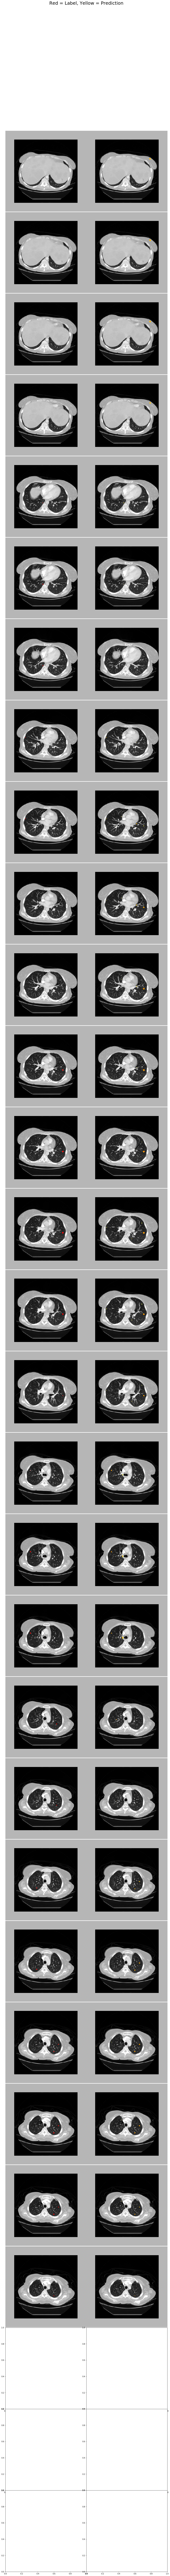

In [24]:
def plot_ct_scan(display_image,display_label,display_pred, plot_size=250, cmap=plt.cm.gray):
    layers = find_list_marked(display_label,display_pred)
    f, plots = plt.subplots(30, 2, figsize=(plot_size, plot_size))
    f.suptitle('Red = Label, Yellow = Prediction', fontsize=25, y=0.92, x=0.025)
    for i in range(len(layers)):
        x = layers[i]
        label =  np.ma.masked_where((display_label[x] < 0.05), display_label[x])
        pred_mask = np.ma.masked_where((display_pred[x] < 0.25), display_pred[x])
        plots[int(i), 0].axis('off')
        plots[int(i), 1].axis('off')
        plots[int(i), 0].imshow(display_image[x], cmap="gray") 
        plots[int(i), 1].imshow(display_image[x], cmap="gray") 
        plots[int(i), 0].imshow(label[:, :],cmap="hsv", alpha=1.0) 
        plots[int(i), 1].imshow(pred_mask[:,:], cmap="Wistia", alpha=1.0)
        plt.subplots_adjust(wspace=0, hspace=0, left=0, right=0.05)

plot_ct_scan(display_image,display_label,display_pred)